In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

,f0,f1,f2,f3,f4,f5,f6,f7,choice
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.513182,0.503980,0.490007,0.489246,0.495571,0.498932,0.495155,0.500955,1.43040
std,0.288809,0.287727,0.294875,0.291247,0.289776,0.290331,0.288827,0.288498,1.07288
min,0.000072,0.000367,0.000664,0.000074,0.000150,0.000207,0.000200,0.000166,0.00000
25%,0.270994,0.267378,0.237860,0.232766,0.239850,0.244728,0.246847,0.251497,0.00000
50%,0.506011,0.491099,0.490484,0.471679,0.498367,0.499909,0.494698,0.500175,1.00000
75%,0.764228,0.763777,0.740046,0.748689,0.745876,0.753624,0.742816,0.752959,2.00000
max,0.999949,0.999964,0.999809,0.999931,0.999962,0.999957,0.999801,0.999978,3.00000


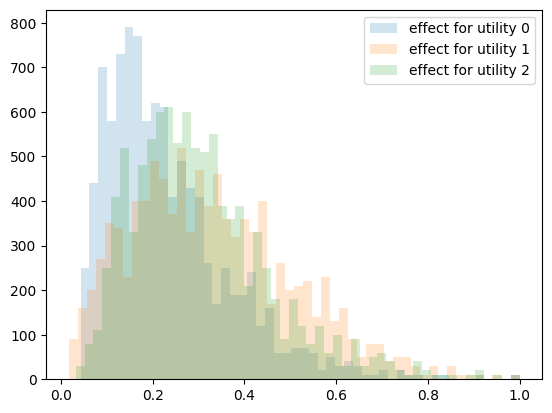

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from rumboost.metrics import mse, cross_entropy
np.random.seed(0)

def compute_levels(sp, betas):
    levels = np.zeros(len(sp))
    for i in range(len(sp) - 1):
        levels[i + 1] = levels[i] + (sp[i + 1] - sp[i]) * betas[i]
    return levels


def create_pw_linear_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    levels = compute_levels(sp, betas) + intercept
    f_x = levels[indices] + betas[indices] * (x - sp[indices])

    return f_x


def apply_linear_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_linear_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_pw_constant_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = betas[indices] + intercept

    return f_x

def apply_constant_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_constant_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data

def create_sinusoidal_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    f_x = np.sin(betas[indices] * x) + intercept
    return f_x

def apply_sinusoidal_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_sinusoidal_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_dataset(x_arr: np.ndarray, feature_names: list) -> pd.DataFrame:
    return pd.DataFrame({feature_names[i]: x_arr[:, i] for i in range(x_arr.shape[1])})


def generate_x(n, k, props_low=0.5, cut=0.5, deterministic=False, gaussian=False, semi_random=False, n_socio_dem=0, panel_factor=1):
    n_s = int(n / panel_factor)

    #socio-demographic variables
    if n_socio_dem > 0:
        n_low_s = int(props_low * n_s)
        n_high_s = n_s - n_low_s

        if deterministic:
            x_low = np.linspace([0]*n_socio_dem, [cut]*n_socio_dem, n_low_s)
            x_high = np.linspace([cut]*n_socio_dem, [1]*n_socio_dem, n_high_s)
        elif gaussian:
            x_low = np.random.normal(loc=0, scale=cut, size=(n_low_s, n_socio_dem))
            x_high = np.random.normal(loc=cut, scale=1-cut, size=(n_high_s, n_socio_dem))
            x_low = np.clip(x_low, 0, cut)
            x_high = np.clip(x_high, cut, 1)
        elif semi_random:
            x_low = np.random.choice(np.linspace(0, cut-1, cut), (n_low_s, n_socio_dem))
            x_high = np.random.choice(np.linspace(cut-1, cut, cut), (n_high_s, n_socio_dem))
        else:
            x_low = np.random.uniform(0, 1, (n_low_s, n_socio_dem))
            x_high = np.random.uniform(0, 1, (n_high_s, n_socio_dem))
        x_socio_dem = np.concatenate([x_low, x_high], axis=0).repeat(panel_factor, axis=0)
    else:
        x_socio_dem = np.empty((n, 0))

    n_alt_spec = k - n_socio_dem
    n_low = int(props_low * n)
    n_high = n - n_low

    if deterministic:
        x_low = np.linspace([0]*n_alt_spec, [cut]*n_alt_spec, n_low)
        x_high = np.linspace([cut]*n_alt_spec, [1]*n_alt_spec, n_high)
    elif gaussian:
        x_low = np.random.normal(loc=0, scale=cut, size=(n_low, n_alt_spec))
        x_high = np.random.normal(loc=cut, scale=1-cut, size=(n_high, n_alt_spec))
        x_low = np.clip(x_low, 0, cut)
        x_high = np.clip(x_high, cut, 1)
    elif semi_random:
        x_low = np.random.choice(np.linspace(0, cut-1, cut), (n_low, n_alt_spec))
        x_high = np.random.choice(np.linspace(cut-1, cut, cut), (n_high, n_alt_spec))
    else:
        x_low = np.random.uniform(0, cut, (n_low, n_alt_spec))
        x_high = np.random.uniform(cut, 1, (n_high, n_alt_spec))

    x_alt_spec = np.concatenate([x_low, x_high], axis=0)

    return np.concatenate([x_socio_dem, x_alt_spec], axis=1)

def nullify_features(x_arr: np.ndarray, feature_indices: list) -> np.ndarray:
    """
    Nullify the features in the dataset by setting them to zero.
    """
    x_arr[:, feature_indices] = np.zeros((x_arr.shape[0], len(feature_indices)))
    return x_arr

def create_simple_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> np.ndarray:
    """
    Create functional effects for a given number of utilities and features per utility.
    """
    effects = np.zeros((x.shape[0], n_utility))
    for i in range(n_utility):
        if i == 0:
            effects[:, i] = np.sum(x[:, :1], axis=1) + np.random.gumbel(0, 0.1, size=x.shape[0])
        elif i == 1:
            effects[:, i] = np.sum(x[:, 1:2], axis=1) + np.random.gumbel(0, 0.1, size=x.shape[0])
        elif i == 2:
            effects[:, i] = np.sum(x[:, 2:3], axis=1) + np.random.gumbel(0, 0.1, size=x.shape[0])
        # else:
        #     effects[:, i] = np.median(x[:, :n_socio_dem], axis=1)

        # effects[:, i] = effects[:,i] / effects[:, i].max()
        # effects[:, i] = ((effects[:, i] - effects[:, i].mean())/effects[:, i].std())

        # effects[:, i] += np.random.normal(loc=0, scale=0.1, size=effects[:, i].shape)

    # effects = effects - effects[:, -1].reshape(-1, 1)
            
    return effects

def create_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> np.ndarray:
    """
    Create functional effects for a given number of utilities and features per utility.
    """
    effects = np.zeros((x.shape[0], n_utility))
    for i in range(n_utility):
        if i == 0:
            effects[:, i] = np.prod(np.exp(x[:, :n_socio_dem]), axis=1)
        elif i == 1:
            effects[:, i] = np.sum(x[:, :n_socio_dem], axis=1) ** 2
        elif i == 2:
            # effects[:, i] = np.prod(x[:, :n_socio_dem], axis=1) 
            effects[:, i] = - np.log(np.prod(x[:, :n_socio_dem], axis=1))

        if i < n_utility - 1:
            effects[:, i] = effects[:, i] / effects[:, i].max()
        # effects[:, i] = ((effects[:, i] - effects[:, i].mean())/effects[:, i].std())

        # effects[:, i] += np.random.normal(loc=0, scale=0.1, size=effects[:, i].shape)

    # effects = effects - effects[:, -1].reshape(-1, 1)
            
    return effects

def create_dumb_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> np.ndarray:
    """
    Create functional effects for a given number of utilities and features per utility.
    """
    effects = np.zeros((x.shape[0], n_utility))
    for i in range(n_utility):
        if i == 0:
            effects[:, i] = np.where(x[:, :n_socio_dem].sum(axis=1) < 2, 1, 0)
        elif i == 1:
            effects[:, i] = np.where(x[:, :n_socio_dem].sum(axis=1) < 2, 1, -1)
        elif i == 2:
            effects[:, i] = np.where(x[:, :n_socio_dem].sum(axis=1) < 2, 0.5, -0.5)
        else:
            effects[:, i] = np.where(x[:, :n_socio_dem].sum(axis=1) < 2, 2, 1)

        # effects[:, i] /= effects[:, i].max()

        # effects[:, i] += np.random.normal(loc=0, scale=0.1, size=effects[:, i].shape)

            
    return effects

def apply_functional_effects(x: np.ndarray, n_utility: int, n_socio_dem: int) -> pd.DataFrame:
    """
    Apply functional effects to the input data and return a DataFrame.
    """
    # effects = create_simple_functional_effects(x, n_utility, n_socio_dem)
    effects = create_functional_effects(x, n_utility, n_socio_dem)
    # effects = create_dumb_functional_effects(x, n_utility, n_socio_dem)
    feature_names = [f"f{i}" for i in range(n_utility)]
    
    return pd.DataFrame(effects, columns=feature_names)

def add_alt_spec_features(dataset_transformed: pd.DataFrame, x_alt: np.ndarray, n_utility: int, coeff: list, n_socio_dem: int) -> pd.DataFrame:
    """
    Add alternative specific features to the transformed dataset.
    """
    
    for i in range(n_utility):
        dataset_transformed.iloc[:, i] += coeff[i] * x_alt[:, i + n_socio_dem]
        # dataset_transformed.iloc[:, i] += coeff[i] * x_alt[:, n_socio_dem]
        # dataset_transformed.iloc[:, i] += np.sum(coeff * x_alt[:, n_socio_dem:], axis=1)

    
    return dataset_transformed

def add_choice(row, u_idx, regression=False):
    u = np.array([np.sum(row[u_idx[i][0] : u_idx[i][1]]) for i in range(len(u_idx))])
    u = u + np.random.gumbel(0, 0.5, size=u.shape[0])
    # p = u-u.min()
    # p = p/(p.sum())
    p = softmax(u)
    if regression:
        return u[0]
    else:
        return np.random.choice(u.shape[0], size=1, p=p)[0]
        # return np.argmax(u) 

n_utility = 4
regression = n_utility == 1
f_per_utility = 5
n_alt_spec = 1
n_socio_dem = 4
tot_features = n_socio_dem + n_utility * n_alt_spec
x_arr = generate_x(10000, tot_features, 1, 1, gaussian=False, semi_random=False, n_socio_dem=n_socio_dem, panel_factor = 10)
x_arr_test = generate_x(2000, tot_features, 1, 1, gaussian=False, semi_random=False, n_socio_dem=n_socio_dem, panel_factor = 10)
# x_arr = nullify_features(x_arr, [i + n_socio_dem for i in range(n_utility)])
# x_arr_test = nullify_features(x_arr_test, [i + n_socio_dem for i in range(n_utility)])

coeff = [-1, -1, -1, -1]
# coeff = [0, 0, 0, 0]

feature_names = [f"f{i}" for i in range(tot_features)]

u_idx = [(i, (i+1)) for i in range(n_utility)]

y_plot = apply_functional_effects(x_arr, n_utility, n_socio_dem)
for i in range(n_utility):
    if i == n_utility - 1:
        continue
    plt.hist(y_plot.iloc[:, i] - y_plot.iloc[:, n_utility - 1], label = f"effect for utility {i}", alpha = 0.2, bins=50)
    plt.legend()

dataset = create_dataset(x_arr, feature_names)
dataset_transf = apply_functional_effects(x_arr, n_utility, n_socio_dem)
dataset_transf = add_alt_spec_features(dataset_transf, x_arr, n_utility, coeff, n_socio_dem)
dataset["choice"] = dataset_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)
dataset_test = create_dataset(x_arr_test, feature_names)
dataset_test_transf = apply_functional_effects(x_arr_test, n_utility, n_socio_dem)
dataset_test_transf = add_alt_spec_features(dataset_test_transf, x_arr_test, n_utility, coeff, n_socio_dem)
dataset_test["choice"] = dataset_test_transf.apply(add_choice, axis=1, u_idx=u_idx, regression=regression)

dataset.describe()

In [3]:
np.random.gumbel(0, 0.25, size=100000).min()

np.float64(-0.6566669182905532)

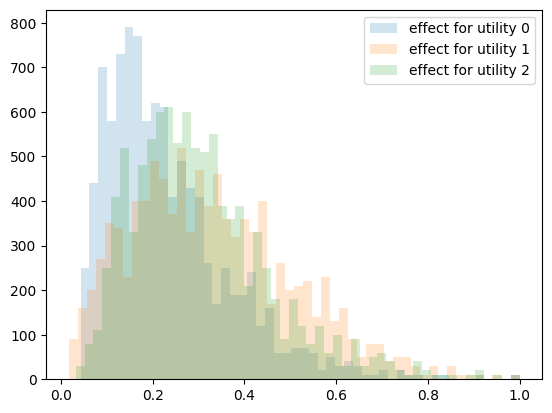

In [4]:
all_bin_edges = []
for i in range(n_utility):
    if i == n_utility - 1:
        continue
    _, bin_edges = np.histogram(dataset_transf.values[:, i] + x_arr[:, i+n_socio_dem], bins=50)
    all_bin_edges.append(bin_edges)
    # plt.hist(np.argmax(dataset_transf, axis=1), label = f"effect for utility {i}", alpha = 0.2, bins=50)
    plt.hist(dataset_transf.values[:, i] + x_arr[:, i+n_socio_dem], bins=bin_edges, label = f"effect for utility {i}", alpha = 0.2)
    plt.legend()

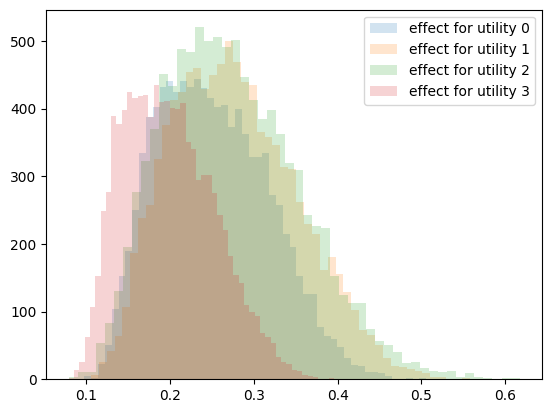

In [5]:
for i in range(n_utility):
    # plt.hist(np.argmax(dataset_transf, axis=1), label = f"effect for utility {i}", alpha = 0.2, bins=50)
    plt.hist((softmax(dataset_transf.values, axis=1)[:, i]), label = f"effect for utility {i}", alpha = 0.2, bins=50)
    plt.legend()

In [6]:
from models_wrapper import RUMBoost, TasteNet
from parser import parse_cmdline_args
from synthetic_experiment import gather_functional_intercepts, l1_distance

alt_spec_features = {i: [f"f{i+n_socio_dem}"] for i in range(n_utility)}
# alt_spec_features = {i: [f"f{n_socio_dem}"] for i in range(n_utility)}
# alt_spec_features = {i: [f"f4", "f5", "f6", "f7"] for i in range(n_utility)}
# alt_spec_features = {0: []}
socio_demo_chars = [f"f{i}" for i in range(n_socio_dem)]
X_train = dataset.drop(columns=["choice"])
X_val = dataset_test.drop(columns=["choice"])
y_train = dataset["choice"]
y_val = dataset_test["choice"]

In [7]:
socio_demo_chars

['f0', 'f1', 'f2', 'f3']

In [8]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [16]:
model = "RUMBoost"
args = parse_cmdline_args()
args.functional_intercept = True
args.functional_params = False
args.feature_fraction = 1.0
args.save_model =False 
args.model = model
args.dataset = "synthetic"
args.learning_rate = 0.5
args.device = "cuda"
args.num_iterations = 1000
args.early_stopping_rounds = 10 
args.num_leaves = 7
# args.max_depth = -1
# args.lambda_l1 = 1
# args.lambda_l2 = 10
# args.min_data_in_bin = 100
# args.min_data_in_leaf = 100
# args.min_sum_hessian_in_leaf = 1
# args.max_bin = 64

model = RUMBoost(
    alt_spec_features=alt_spec_features,
    socio_demo_chars=socio_demo_chars,
    num_classes=n_utility,
    args=args,
    )

# build dataloader
model.build_dataloader(X_train, y_train, X_val, y_val)

# fit model
best_train_loss, best_val_loss = model.fit()


# predict on the test set
preds, _, _ = model.predict(X_val)
if regression:
    loss_test = mse(preds, y_val)
else:
    loss_test = cross_entropy(preds, y_val)



/home/nicolas-salvade/panel-data/src/rumboost/rumboost.py:2680: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[1]------NCE value on train set : 1.3804
---------NCE value on test set 1: 1.3814
[11]-----NCE value on train set : 1.3480
---------NCE value on test set 1: 1.3575
[21]-----NCE value on train set : 1.3344
---------NCE value on test set 1: 1.3518
[31]-----NCE value on train set : 1.3268
---------NCE value on test set 1: 1.3505
[41]-----NCE value on train set : 1.3216
---------NCE value on test set 1: 1.3501
[51]-----NCE value on train set : 1.3175
---------NCE value on test set 1: 1.3504
Early stopping at iteration 41, with a best score on test set of 1.3501254320144653, and on train set of 1.317161202430725


In [17]:
dummy_data = pd.DataFrame(np.zeros((1, tot_features)), columns=feature_names)
model.model.asc

tensor([0., 0., 0., 0.], device='cuda:0', dtype=torch.float64)

In [18]:
"f4" in ["f4", "f5", "f6", "f7"]

True

In [19]:
model.rum_structure

[{'variables': ['f4'],
  'utility': [0],
  'boosting_params': {'monotone_constraints_method': 'advanced',
   'max_depth': -1,
   'n_jobs': -1,
   'learning_rate': np.float64(0.0625),
   'verbose': -1,
   'monotone_constraints': [-1],
   'interaction_constraints': [[0]],
   'num_leaves': 7,
   'min_gain_to_split': 0.0,
   'min_sum_hessian_in_leaf': 0.001,
   'max_bin': 255,
   'min_data_in_bin': 3,
   'min_data_in_leaf': 20,
   'feature_fraction': 1.0,
   'bagging_fraction': 1.0,
   'bagging_freq': 0,
   'lambda_l1': 0.0,
   'lambda_l2': 0.0},
  'shared': False},
 {'variables': ['f5'],
  'utility': [1],
  'boosting_params': {'monotone_constraints_method': 'advanced',
   'max_depth': -1,
   'n_jobs': -1,
   'learning_rate': np.float64(0.0625),
   'verbose': -1,
   'monotone_constraints': [-1],
   'interaction_constraints': [[0]],
   'num_leaves': 7,
   'min_gain_to_split': 0.0,
   'min_sum_hessian_in_leaf': 0.001,
   'max_bin': 255,
   'min_data_in_bin': 3,
   'min_data_in_leaf': 20,
   

In [21]:
dico = {"a": 0, "b": 1}

In [25]:
["c"] + list(dico.keys())

['c', 'a', 'b']

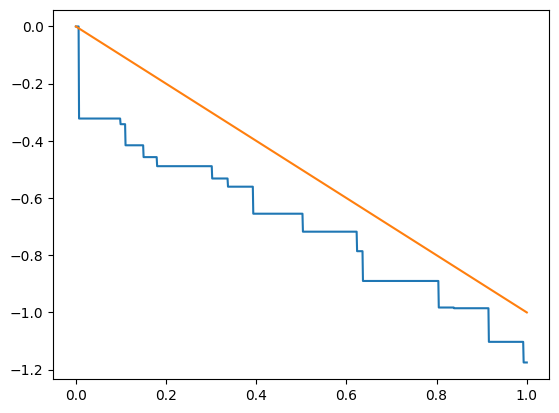

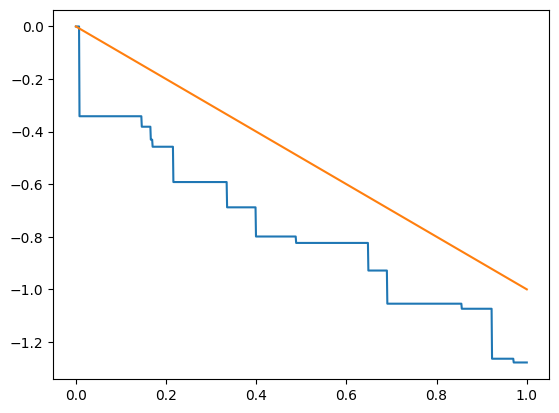

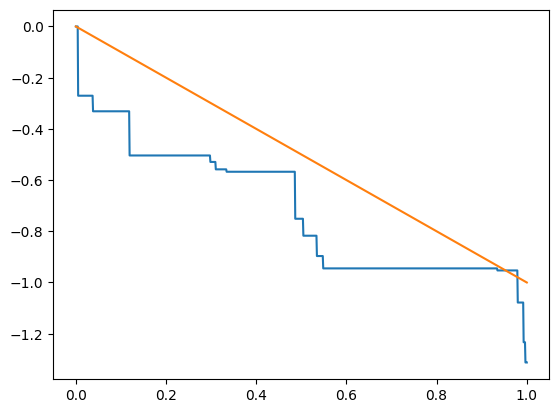

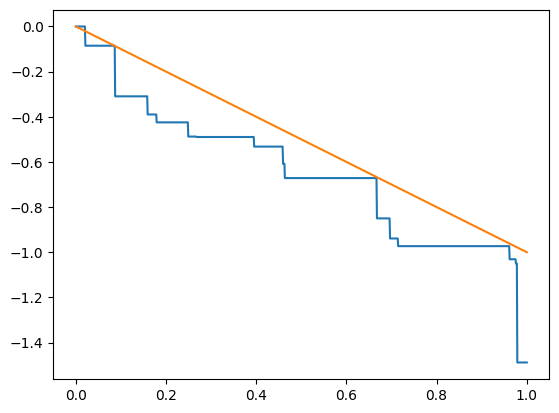

In [20]:
x_plot = np.linspace(0, 1, 1000).reshape(-1, 1)
y_alt = []
asc = []
for i, booster in enumerate(model.model.boosters[:-n_utility]):
    plt.figure()
    y_plot = booster.predict(x_plot)
    y_a = booster.predict(dataset.iloc[:, i+n_socio_dem].values.reshape(-1,1))
    asc.append(y_plot[0])
    plt.plot(x_plot, y_plot - asc[i], label="predicted utility")
    plt.plot(x_plot, coeff[i] *x_plot, label="true utility")
    y_alt.append(y_a)


In [28]:
# get learnt functional intercepts
learnt_fct_intercepts = gather_functional_intercepts(
    dataset, model, socio_demo_chars, n_utility, alt_normalised=n_utility - 1
)
learnt_fct_intercepts_test = gather_functional_intercepts(
    dataset_test, model, socio_demo_chars, n_utility, alt_normalised=n_utility - 1
)

# compute L1 distance between true and learnt functional intercepts
l1_distance_train = l1_distance(
    dataset_transf - coeff * x_arr[:, n_socio_dem:],
    learnt_fct_intercepts,
)
l1_distance_test = l1_distance(
    dataset_test_transf - coeff * x_arr_test[:, n_socio_dem:],
    learnt_fct_intercepts_test,
)

print(f"Best Train Loss: {best_train_loss}, Best Val Loss: {best_val_loss}")
print(f"Test Loss: {loss_test}")

Best Train Loss: 1.3467415571212769, Best Val Loss: 1.3491489887237549
Test Loss: 1.3492122108136062


In [29]:
print(f"L1 Distance Train: {l1_distance_train}, L1 Distance Test: {l1_distance_test}")

L1 Distance Train: f0    7107.990184
f1    8032.218336
f2    9243.632675
f3       0.000000
dtype: float64, L1 Distance Test: f0    1538.211483
f1    1700.515987
f2    2215.603524
f3       0.000000
dtype: float64


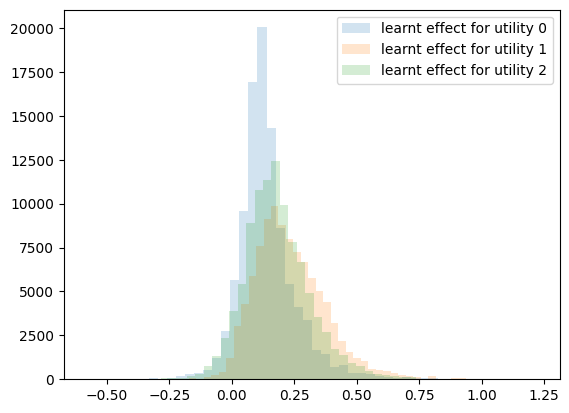

In [30]:
for i in range(n_utility):
    if i == n_utility - 1:
        continue
    # hist = np.where(learnt_fct_intercepts[:,i] + asc[i] - learnt_fct_intercepts[:,n_utility - 1] - asc[n_utility - 1] < 0, 0.01, np.where(learnt_fct_intercepts[:,i] + asc[i] - learnt_fct_intercepts[:,n_utility - 1] - asc[n_utility - 1] > 1, 0.99, learnt_fct_intercepts[:,i] + asc[i] - learnt_fct_intercepts[:,n_utility - 1] - asc[n_utility - 1]))
    # hist = learnt_fct_intercepts[:,i] + y_alt[i] - learnt_fct_intercepts[:,n_utility - 1] - y_alt[n_utility - 1]
    hist = learnt_fct_intercepts[:,i] 
    # hist = learnt_fct_intercepts[:,i] + y_alt[i]
    # hist = learnt_fct_intercepts[:,i] - learnt_fct_intercepts[:,n_utility - 1] 
    # hist = learnt_fct_intercepts[:,i]
    # plt.hist(hist, label = f"learnt effect for utility {i}", alpha = 0.2, bins=all_bin_edges[i])
    plt.hist(hist, label = f"learnt effect for utility {i}", alpha = 0.2, bins=50)
    # plt.hist(learnt_fct_intercepts[:,i] + y_alt[i], label = f"learnt effect for utility {i}", alpha = 0.2, bins=50)
    # plt.hist(softmax(learnt_fct_intercepts_test,axis=1)[:,i], label = f"learnt effect for utility {i}", alpha = 0.2, bins=50)
    plt.legend()

In [31]:
from models_wrapper import RUMBoost, TasteNet
from parser import parse_cmdline_args
from synthetic_experiment import gather_functional_intercepts, l1_distance

alt_spec_features = {i: [f"f{i+n_socio_dem}"] for i in range(n_utility)}
# alt_spec_features = {i: [f"f{n_socio_dem}"] for i in range(n_utility)}
# alt_spec_features = {i: [f"f4", "f5", "f6", "f7"] for i in range(n_utility)}
# alt_spec_features = {0: []}
socio_demo_chars = [f"f{i}" for i in range(n_socio_dem)]
X_train = dataset.drop(columns=["choice"])
X_val = dataset_test.drop(columns=["choice"])
y_train = dataset["choice"]
y_val = dataset_test["choice"]

In [20]:
model = "TasteNet"
args = parse_cmdline_args()
args.functional_intercept = True
args.functional_params = False
args.feature_fraction = 1.0
args.save_model = False 
args.model = model
args.dataset = "synthetic"
args.device = "cuda"


model = TasteNet(
    alt_spec_features=alt_spec_features,
    socio_demo_chars=socio_demo_chars,
    num_classes=n_utility,
    num_latent_vals=None,
    args=args,
)

y_train = y_train.astype(int)
y_val = y_val.astype(int)

# build dataloader
model.build_dataloader(X_train, y_train, X_val, y_val)

# fit model
best_train_loss, best_val_loss = model.fit()


# predict on the test set
preds, _, _ = model.predict(X_val)
loss_test = cross_entropy(preds, y_val)



/home/nicolas-salvade/miniforge3/envs/share/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


--- Batch 0/391, loss: 1.3813
--- Batch 50/391, loss: 1.3946
--- Batch 100/391, loss: 1.3792
--- Batch 150/391, loss: 1.3666
--- Batch 200/391, loss: 1.3915
--- Batch 250/391, loss: 1.3836
--- Batch 300/391, loss: 1.3679
--- Batch 350/391, loss: 1.3761
Epoch 1/200: train loss = 1.3797, val. loss: 1.3697
--- Batch 0/391, loss: 1.3728
--- Batch 50/391, loss: 1.3783
--- Batch 100/391, loss: 1.3693
--- Batch 150/391, loss: 1.3538
--- Batch 200/391, loss: 1.3608
--- Batch 250/391, loss: 1.3673
--- Batch 300/391, loss: 1.3656
--- Batch 350/391, loss: 1.3532
Epoch 2/200: train loss = 1.3686, val. loss: 1.3602
--- Batch 0/391, loss: 1.3859
--- Batch 50/391, loss: 1.3624
--- Batch 100/391, loss: 1.3656
--- Batch 150/391, loss: 1.3623
--- Batch 200/391, loss: 1.3500
--- Batch 250/391, loss: 1.3543
--- Batch 300/391, loss: 1.3622
--- Batch 350/391, loss: 1.3565
Epoch 3/200: train loss = 1.3619, val. loss: 1.3546
--- Batch 0/391, loss: 1.3536
--- Batch 50/391, loss: 1.3637
--- Batch 100/391, loss:

Parameter containing:
tensor([[-0.8848]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.8904]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.8238]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.9244]], device='cuda:0', requires_grad=True)


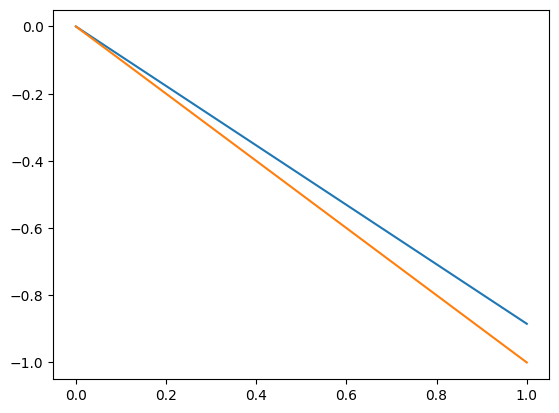

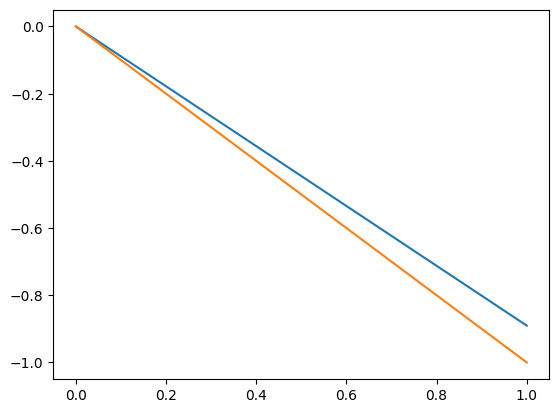

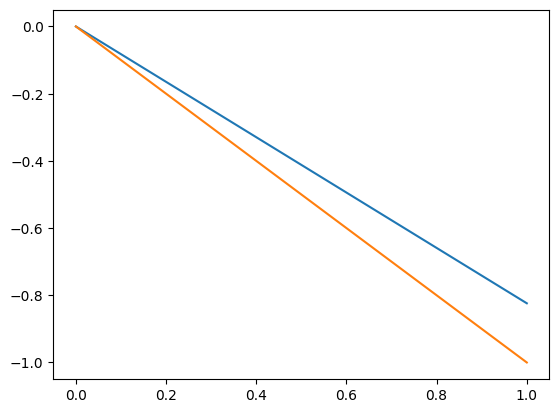

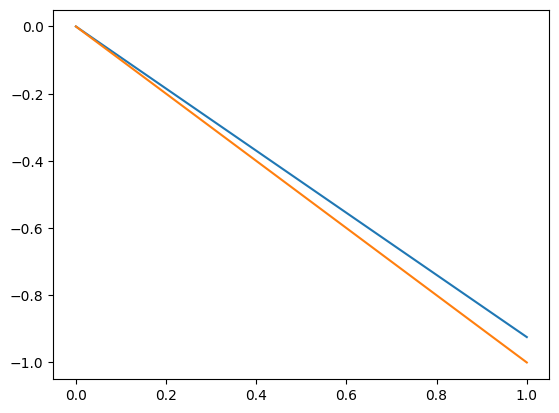

In [21]:
x_plot = np.linspace(0, 1, 1000).reshape(-1, 1)
y_alt = []
asc = []
tastenet_params = np.array([])
for param in model.model.util_module.mnl.mnl.parameters():
    tastenet_params = np.concatenate(
        [tastenet_params, param.detach().cpu().numpy()[0]]
    )
    print(param)

for param in tastenet_params:
    plt.figure()
    y_plot = param * x_plot
    plt.plot(x_plot, y_plot, label="predicted utility")
    plt.plot(x_plot, coeff[i] *x_plot, label="true utility")


In [106]:
# get learnt functional intercepts
learnt_fct_intercepts = gather_functional_intercepts(
    dataset, model, socio_demo_chars, n_utility, alt_normalised=n_utility - 1
)
learnt_fct_intercepts_test = gather_functional_intercepts(
    dataset_test, model, socio_demo_chars, n_utility, alt_normalised=n_utility - 1
)

# compute L1 distance between true and learnt functional intercepts
l1_distance_train = l1_distance(
    dataset_transf - coeff * x_arr[:, n_socio_dem:],
    learnt_fct_intercepts,
)
l1_distance_test = l1_distance(
    dataset_test_transf - coeff * x_arr_test[:, n_socio_dem:],
    learnt_fct_intercepts_test,
)

print(f"Best Train Loss: {best_train_loss}, Best Val Loss: {best_val_loss}")
print(f"Test Loss: {loss_test}")

Best Train Loss: 1.3443766475638466, Best Val Loss: 1.34249533882624
Test Loss: 1.3426543474197388


In [107]:
print(f"L1 Distance Train: {l1_distance_train}, L1 Distance Test: {l1_distance_test}")

L1 Distance Train: f0    50251.585774
f1    53366.396771
f2    53954.053294
f3    49831.167566
dtype: float64, L1 Distance Test: f0    460.030904
f1    832.283679
f2    844.503058
f3      0.000000
dtype: float64


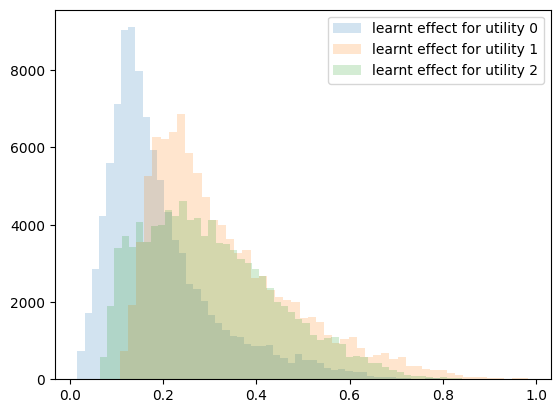

In [108]:
for i in range(n_utility):
    if i == n_utility - 1:
        continue
    hist = learnt_fct_intercepts[:,i]
    plt.hist(hist, label = f"learnt effect for utility {i}", alpha = 0.2, bins=50)
    plt.legend()